![](https://assets.website-files.com/60e7f71b22c6d0b9cf329ceb/621e1a2f28ded71ee95aeede_6ProvenSalesForecastingMethodstoDriveRevenue1_a117440b5ae227c3dba5264a6521da06_2000.png)

# Introdução

O objetivo deste projeto é desenvolver um modelo de forecasting para prever a demanda dos próximos 5 dias do item da empresa **Frexco**, baseado em uma série temporal. Para essa previsão será utilizado o modelo ARIMA.

# Data Cleaning

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_excel('Dados.xlsx', index_col=0)

In [3]:
df = df.reset_index(level=0)

In [4]:
df.head()

,Data,Vendas
0,2022-12-06,870
1,2022-12-07,868
2,2022-12-08,1189
3,2022-12-09,742
4,2022-12-10,317


In [5]:
df['Data'] = df['Data'].astype(str)

In [6]:
df[['Ano', 'Mes', 'Dia']] = df['Data'].str.split('-', expand=True).astype(int)
df.head()

,Data,Vendas,Ano,Mes,Dia
0,2022-12-06,870,2022,12,6
1,2022-12-07,868,2022,12,7
2,2022-12-08,1189,2022,12,8
3,2022-12-09,742,2022,12,9
4,2022-12-10,317,2022,12,10


# Análise Exploratória de Dados (EDA)

In [7]:
import seaborn as sns
import plotly.express as px

In [8]:
import plotly.io as pio
pio.renderers.default = "svg"

In [9]:
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


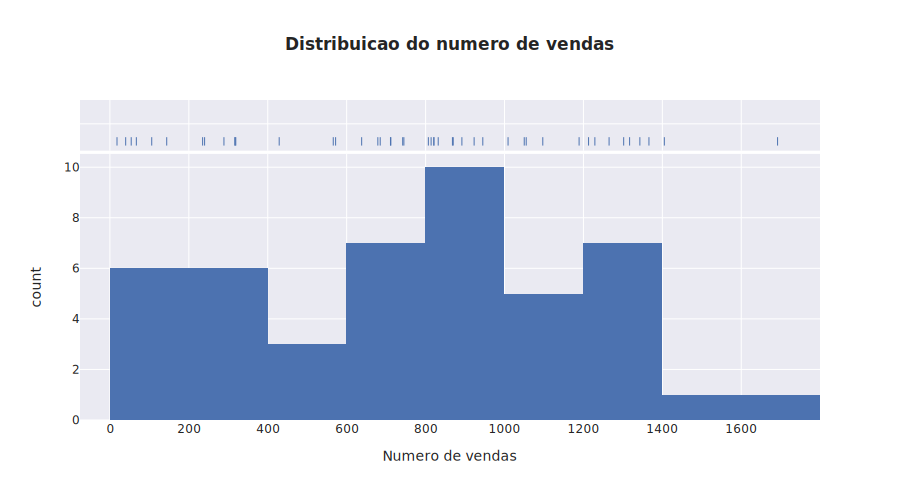

In [10]:
px.histogram(df,x='Vendas', width=900, marginal='rug',template='seaborn',labels={'Vendas':'Numero de vendas'},title="<b> Distribuicao do numero de vendas")

A maior frequência de número de vendas está no intervalo de 800 a 1000 vendas.

In [11]:
vendas = np.array(df['Vendas'])

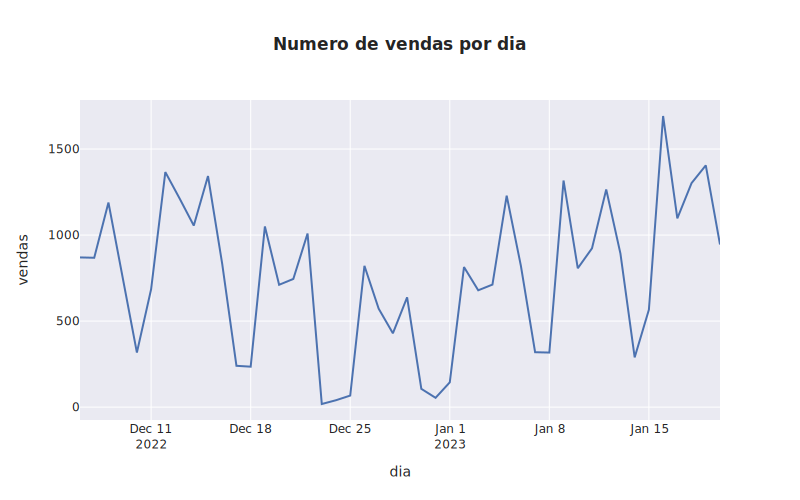

In [12]:
fig = px.line(df, x="Data", y="Vendas", width=800, labels={'Data':'dia','Vendas':'vendas'}, template="seaborn",title="<b> Numero de vendas por dia")
fig.show()

In [13]:
z = df.sort_values('Vendas', ascending=False).reset_index(drop=True)

In [14]:
z = z[['Data', 'Vendas']]

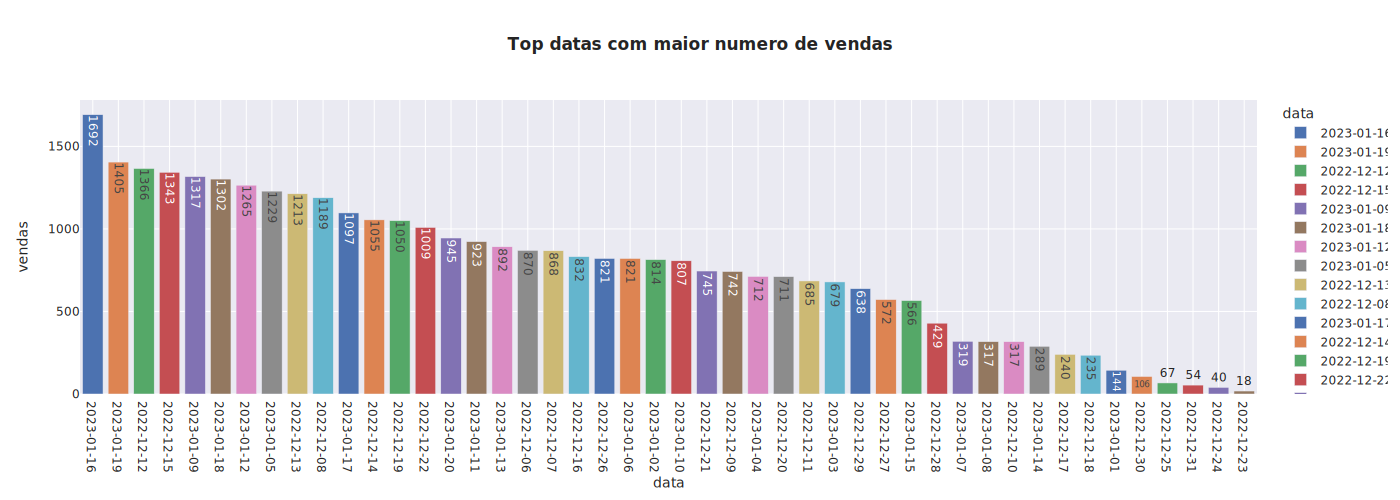

In [15]:
fig=px.bar(z,x='Data',y='Vendas',color='Data', width=1400,
           labels={'Data':'data','Vendas':'vendas'},text='Vendas',template='seaborn',title="<b> Top datas com maior numero de vendas")

fig.update_layout(
xaxis_type = 'category'
)

fig.show()

In [16]:
z = df[df['Dia'] <= 20]
z = df.groupby('Mes', as_index=False)[['Vendas']].sum().sort_values(by='Vendas',ascending=False)
z = z.replace(1, 'Janeiro de 2023')
z = z.replace(12, 'Dezembro de 2022')

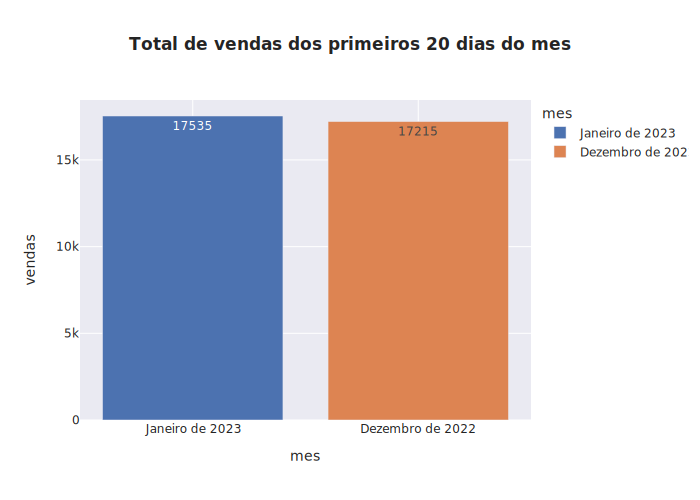

In [17]:
fig=px.bar(z,x='Mes',y='Vendas',color='Mes',
           labels={'Mes':'mes','Vendas':'vendas'},text='Vendas',template='seaborn',title="<b> Total de vendas dos primeiros 20 dias do mes")

fig.show()

# Machine Learning

## Data Visualization

In [18]:
data = pd.DataFrame(df['Vendas'])

In [19]:
data.head()

,Vendas
0,870
1,868
2,1189
3,742
4,317


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Vendas  46 non-null     int64
dtypes: int64(1)
memory usage: 496.0 bytes


In [21]:
# descrição da coluna de vendas
data.describe()['Vendas']

count      46.000000
mean      755.434783
std       430.762201
min        18.000000
25%       346.500000
50%       810.500000
75%      1053.750000
max      1692.000000
Name: Vendas, dtype: float64

In [22]:
# checando nulos
data.isnull().sum()

Vendas    0
dtype: int64

### Reescalando os dados

In [23]:
from sklearn.preprocessing import StandardScaler

In [24]:
scaler = StandardScaler()

scaler.fit(pd.DataFrame(data['Vendas']))

data['Vendas'] = scaler.transform(pd.DataFrame(data['Vendas']))

In [25]:
data.head()

,Vendas
0,0.268898
1,0.264204
2,1.017629
3,-0.031533
4,-1.029059


## Build Model

### Seleção de hiperparâmetros

#### Checando se os dados são estacionários pelo teste ADF

In [26]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
from pmdarima.arima import ADFTest 

In [28]:
adf = ADFTest(alpha = 0.05)
adf.should_diff(data["Vendas"])

(0.32861105775592403, True)

Como o p-value foi maior que 0.05, isso significa que a série temporal **não é estacionária**.

#### Transformando a time series em estacionária

In [29]:
# aumentando a ordem de diferenciação

data["diff_1"] = data["Vendas"].diff(periods=1)
data["diff_2"] = data["Vendas"].diff(periods=2)
data["diff_3"] = data["Vendas"].diff(periods=3)

In [30]:
adf = ADFTest(alpha = 0.05)
print(f'p-value diff 1: {adf.should_diff(data["diff_1"].dropna())}')
print(f'p-value diff 2: {adf.should_diff(data["diff_2"].dropna())}')
print(f'p-value diff 3: {adf.should_diff(data["diff_3"].dropna())}')

p-value diff 1: (0.01, False)
p-value diff 2: (0.01, False)
p-value diff 3: (0.01, False)


Os dados agora **são estacionários**, e somente 1 grau de diferenciação (**d=1**) foi necessário.

In [31]:
from statsmodels.graphics.tsaplots import plot_acf

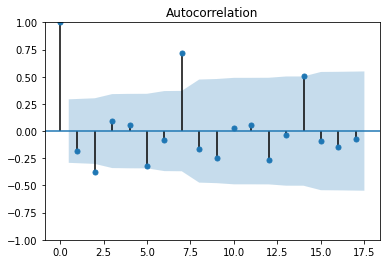

In [32]:
plot_acf(data['diff_1'].dropna());

Como o lag mais significativo é o primeiro, o 'p' será definido como 1. O 'q' será o número de lags que cruzam o threshold, que no caso são 3.

Os parâmetros do modelo ARIMA serão então: **p=1; d=1; q=3**

## Fit

In [33]:
from statsmodels.tsa.arima.model import ARIMA

In [34]:
# build model
model = ARIMA(data.Vendas, order=(1, 1, 3))

In [35]:
model = model.fit()

In [36]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Vendas   No. Observations:                   46
Model:                 ARIMA(1, 1, 3)   Log Likelihood                 -58.262
Date:                Sat, 04 Feb 2023   AIC                            126.525
Time:                        11:21:20   BIC                            135.558
Sample:                             0   HQIC                           129.892
                                 - 46                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6239      0.458     -1.363      0.173      -1.521       0.273
ma.L1          0.2780      0.536      0.519      0.604      -0.772       1.328
ma.L2         -0.7721      0.153     -5.032      0.000      -1.073      -0.471
ma.L3         -0.1333      0.400     -0.333      0.739      -0.917       0.650
sigma2         0.7508      0.209      3.596      0.000       0.342       1.160
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.81
Prob(Q):                              0.91   Prob(JB):                         0.67
Heteroskedasticity (H):               1.47   Skew:                             0.10
Prob(H) (two-sided):                  0.46   Kurtosis:                         2.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Evaluate

In [37]:
import matplotlib.pyplot as plt

In [38]:
from statsmodels.graphics.tsaplots import plot_predict

In [39]:
data_pred = model.predict(dynamic=False)

In [40]:
from sklearn.metrics import mean_squared_error

In [41]:
mean_squared_error(data.Vendas, data_pred)

0.7547602732747043

# Resultados

O **MSR** do modelo foi de aproximadamente **0.75**

## Gráfico Real vs Previsto do modelo ARIMA

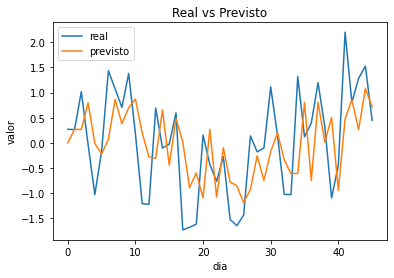

In [42]:
plt.plot(data.Vendas, linestyle = '-', label = 'real')
plt.plot(data_pred, linestyle = '-', label = 'previsto')

plt.xlabel("dia")
plt.ylabel("valor")

plt.title("Real vs Previsto")
plt.legend(loc='best')

plt.show()

## Previsão de vendas dos próximos 5 dias

In [43]:
forecast_next_5_days = pd.DataFrame(scaler.inverse_transform(pd.DataFrame(model.forecast(5))), index = pd.date_range(start='21/1/2023', periods=5)).rename(columns={'index':'Data'})

forecast_next_5_days.columns = ['Vendas']

forecast_next_5_days['Vendas'] = forecast_next_5_days['Vendas'].astype(int)

In [44]:
forecast_next_5_days

,Vendas
2023-01-21,994
2023-01-22,1028
2023-01-23,1022
2023-01-24,1026
2023-01-25,1024


*Muito obrigado por vir até o fim :)*